In [7]:
import os
import math
import plotly
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from yellowbrick.target.feature_correlation import feature_correlation
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# gend_sub_df = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_passenger_id = test_df.PassengerId

In [8]:
# Preprocessing & Setup
# https://www.kaggle.com/alexisbcook/titanic-tutorial

# PassengerId, Name, Ticket not useful features in prediction of survival.
removed_features = ["PassengerId", "Name", "Ticket"]

# Fare, Cabin, and Embarked could be useful so check for missing values. 
# If greater than 20% missing, remove col. Cabin is removed.
na_perc = {col: pd.isna(train_df[col]).sum() / len(train_df[col]) for col in train_df.columns}
removed_features.append(*list(filter(lambda x: na_perc[x] > 0.2, na_perc)))

# Remove features that fail to meet 80% threshold of usable values.
train_df = train_df.loc[:, np.setdiff1d(train_df.columns,removed_features)]
test_df = test_df.loc[:, np.setdiff1d(test_df.columns,removed_features)]

numer_features = ["Age", "Fare"]
categ_features = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]

# Fill nas with mode if categorical and median if measurement
for col in numer_features:
    test_df[col] = test_df[col].fillna(test_df[col].median())
    train_df[col] = train_df[col].fillna(train_df[col].median())

for col in categ_features:
    test_df[col] = test_df[col].fillna(test_df[col].mode())
    train_df[col] = train_df[col].fillna(train_df[col].mode())
    
# Pclass, Sex, SibSP, and Parch are categorical variables so need to replace with dummy vars.
X_train = pd.get_dummies(train_df[categ_features])
X_test = pd.get_dummies(test_df[categ_features])

# join categ_df with numerical_df
X_train = X_train.join(train_df.loc[:, numer_features])
X_test = X_test.join(test_df.loc[:, numer_features])

y_train = train_df.loc[:, "Survived"]

In [16]:
# Feature Correlation
# https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
# https://www.scikit-yb.org/en/latest/api/target/feature_correlation.html

# Correlation of features with survival
# visualizer = feature_correlation(X_train, y_train, labels=X_train.columns)

<AxesSubplot:>

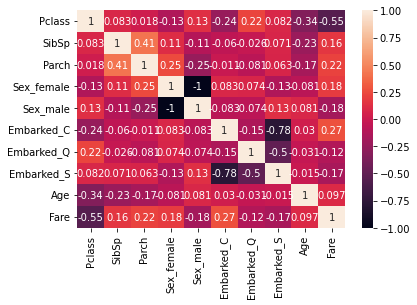

In [9]:
# Create correlation matrix.
corr_mtx = X_train.corr()
sns.heatmap(corr_mtx, annot=True)

In [10]:

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# Can only use measurement variables: Age and fare.
pca_df = train_df.loc[:, ["Age", "Fare"]]

# Feature scaling: standardize values so that mean = 0 and variance = 1 (i.e. properties of a standard normal distribution)
pca_df_standardized = StandardScaler().fit_transform(pca_df)

# Fit and transform values to two principal components
pca = PCA(n_components = 2)
pc = pca.fit_transform(pca_df_standardized)

pca_colnames = [f"PC1 ({round(pca.explained_variance_ratio_[0], 3) * 100}%)", f"PC2 ({round(pca.explained_variance_ratio_[1], 3)* 100}%)"]
df_pc = pd.DataFrame(pc, columns = pca_colnames)
df_pc["Survived"] = train_df[["Survived"]]
df_pc

,PC1 (54.800000000000004%),PC2 (45.2%),Survived
0,-0.755318,0.044754,0
1,1.025804,0.086963,1
2,-0.528344,-0.163000,1
3,0.603899,-0.008896,1
4,-0.037495,-0.650290,0
...,...,...,...
886,-0.401748,-0.145087,0
887,-0.594441,0.531677,1
888,-0.198627,-0.050647,0
889,-0.214054,0.151290,1


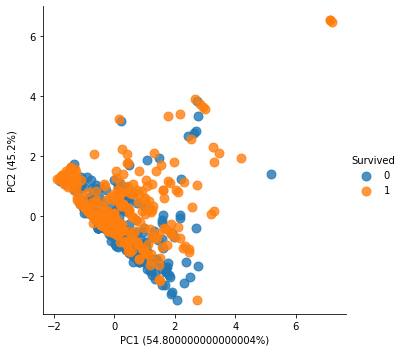

In [11]:
sns.lmplot(x=df_pc.columns[0], y=df_pc.columns[1],
  data=df_pc, 
  fit_reg=False, 
  hue='Survived', # color by if survived
  legend=True,
  scatter_kws={"s": 80}) 

In [12]:
# Random Forest Classifier
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python
n_features = int(math.sqrt(len(X_train.columns)))
clf = RandomForestClassifier(n_estimators = 50, random_state = 42, max_features=n_features)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=50, random_state=42)

Fare          0.267223
Age           0.251272
Sex_male      0.166573
Sex_female    0.113726
Pclass        0.075656
SibSp         0.049019
Parch         0.041286
Embarked_C    0.013413
Embarked_S    0.013413
Embarked_Q    0.008419
dtype: float64

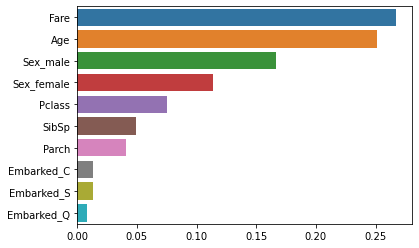

In [13]:
# Feature Importance based on Mean Decrease of Impurity
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Low cardinality features so should be okay?
feature_importance = pd.Series(clf.feature_importances_, X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y = feature_importance.index)
feature_importance

In [14]:
# Remove Embarked columns due to low importance.
low_importance_cols = feature_importance[feature_importance < 0.05].index
X_train = X_train.drop(columns = low_importance_cols)
X_test = X_test.drop(columns = low_importance_cols)

In [15]:
# Fit updated data to rf classifier and predict.
n_features = int(math.sqrt(len(X_test.columns)))
clf = RandomForestClassifier(n_estimators = 50, random_state = 42, max_features=n_features)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
res = pd.DataFrame({"PassengerId": test_passenger_id, "Survived": y_pred})
res.to_csv('submission.csv', index=False)

In [181]:
# param_grid = {
#                  'n_estimators': [5, 10, 50, 500, 1000],
#                  'max_features': [3, 5]
#              }

# grid_clf = GridSearchCV(clf, param_grid, cv=10)
# grid_clf.fit(X_train, y_train)

In [182]:
# grid_clf.best_params_